# Creating a spam filter with the Naive Bayes algorithim

In this project I aim to create a spam filter that filters out spam SMS messages with help of the Naive Bayes algorithim. I will be using a dataset form the UC Irvine machine learning respository named SMS Spam Collection. I will be looking for specific markers on dataset of 5572 SMS messages already classified by humans to teach the computer to mark messages as 'spam' or 'non-spam'. To achieve this will be using the multinomial Naive Bayes Algorithim. The multinomial Niave Bayes formula is as follows:

$$
p(S|w_n) ∝ p(S)⋅∏^{n}_{i=1}p(w_i|S)  \ (1.0)
$$

and for non-spam messages it will just be the complement of the spam messages, donated as 'C':

$$
p(S^C|w_n) ∝ p(S^C)⋅∏^{n}_{i=1}p(w_i|S^C) \ (1.1)
$$
$$
p(S|w_n) = \text{the probability the message is spam with words w_n in it}
$$
$$
p(S^C|w_n) = \text{the probability the message is non-spam with words w_n in it}
$$

In [ ]:
import pandas as pd
sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms.shape)
sms.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
ham = 0
spam = 0
for row in sms['Label']:
    if row == 'ham':
        ham += 1
    else:
        spam += 1
print('non-spam messages(%): ', ham/len(sms)*100)
print('spam messages(%): ', spam/len(sms)*100)

non-spam messages(%):  86.59368269921033
spam messages(%):  13.406317300789663


# Designing a training and a test set

We can see that ~87% of the messages are 'ham' meaning non-spam messages and ~13% are spam messages. Before we acutally make the spam filter software we are going to design a test to see if the software we develop acutally works. We will design the test before because it will cut the bias out of the test. We will split the dataset into two categories:

1. A training set, which will be used to 'train' the computer how to classify the messages.
2. A test set, which will be used to test how good the spam filter is with classifying messages.

We will allocate 80% (4,458 messages) of the data for training the computer and 20% (1,114 messages) for testing, allowing the computer to learn as much as possible will still having enough for testing it. The goal is to create a spam filter that classifies messages with accruacy greater or equal 80%. So first let's create a training set and a test set.

In [ ]:
sms_random = sms.sample(frac=1, random_state=1)
training = sms_random[:4458].reset_index(drop=True)
test = sms_random[4458:].reset_index(drop=True)

print(training.shape)
print(test.shape)

(4458, 2)
(1114, 2)


In [ ]:
print(training['Label'].value_counts(normalize=True))
print(test['Label'].value_counts(normalize=True))

Label
ham     0.86541
spam    0.13459
Name: proportion, dtype: float64
Label
ham     0.868043
spam    0.131957
Name: proportion, dtype: float64


We can see that for both datasets there is roughly an equal distribution of ham and spam messages.

Recalling equations 1.0 and 1.1:

$$
p(S|w_n) ∝ p(S)⋅∏^{n}_{i=1}p(w_i|S)  \ (1.0)
$$

$$
p(S^C|w_n) ∝ p(S^C)⋅∏^{n}_{i=1}p(w_i|S^C) \ (1.1)
$$

We can replace S^C in equation 1.1 with 'ham' for non-spam messages:

$$
p(ham|w_n) ∝ p(ham)⋅∏^{n}_{i=1}p(w_i|ham) \ (1.2)
$$

Also for algorithim we have to account for the correction factors for the p(wi|Spam) and p(wi|ham):

$$
p(w_i|S) = \frac{N_{{w_i}|S} + α}{N_{S}+α⋅N_{vocab}} \ (2.0)
$$

$$
p(w_i|ham) = \frac{N_{{w_i}|ham} + α}{N_{ham}+α⋅N_{vocab}} \ (2.1)
$$

the correction factors are necessary becasue they allow for the 0 probabilities to be dismissed.

The varibales in equations 2.0 and 2.1 can be described as the following:

$$
N_{{w_i}|spam} = \text{the number of times the word w_i occurs in spam messages}
$$
$$
N_{{w_i}|ham} = \text{the number of times the word w_i occurs in non-spam messages}
$$
$$
N_{spam} = \text{total number of spam messages}
$$
$$
N_{ham} = \text{total number of non-spam messages}
$$
$$
α = \text{Laplace smoothing coefficient} = 1
$$


In [ ]:
#  breaking down the SMS script for better processing
sms_clean = training.copy()
import re
sms_clean['SMS'] = sms_clean['SMS'].str.replace(r'[^\w\s]','', regex=True).str.lower()
sms_clean.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth theres a card on da ...


Our end is to bring the dataset into the following format:

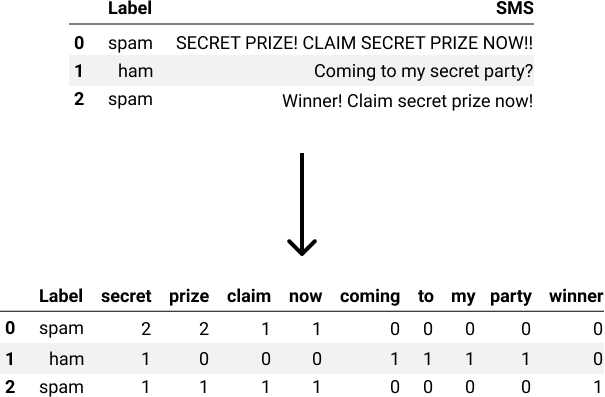

In [ ]:
# making a list of the different words in the all messages
vocab = []
sms_clean['SMS'] = sms_clean['SMS'].str.split()
for sms in sms_clean['SMS']:
    for word in sms:
        vocab.append(word)
vocab = list(set(vocab))
print(len(vocab))
print(vocab[:10])

8448
['supply', 'convincingjust', 'everyone', '2day', 'lotwill', 'consider', 'rejected', 'dream', 'mates', 'handle']


In [ ]:
# making a count of the all words in each message
word_counts_per_sms = {unique_word: [0] * len(sms_clean['SMS']) for unique_word in vocab}
for index, sms in enumerate(sms_clean['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,supply,convincingjust,everyone,2day,lotwill,consider,rejected,dream,mates,handle,...,booking,possibility,requires,wwwphb1com,sweetie,81151,verify,surya,speechless,vu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# now join both tables to get one table to work with
sms_clean_count = pd.concat([sms_clean, word_counts], axis=1)

In [ ]:
sms_clean_count.head()

,Label,SMS,supply,convincingjust,everyone,2day,lotwill,consider,rejected,dream,...,booking,possibility,requires,wwwphb1com,sweetie,81151,verify,surya,speechless,vu
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, theres, a, c...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looking at equations 1.0, 1.2, 2.0, and 2.1 there some constants we can calculate first to make our life easier. The constants are:

1. p(s), p(ham) from (1.0) and (1.2)
2. N(spam), N(ham), N(vocab) from (2.1) and (2.2)

We are also going to use Laplace smoothing with α=1

In [ ]:
# calculate the proability of spam and non-spam messages (ratio)
p_ham = round(sms_clean_count['Label'].value_counts(normalize=True)['ham'],4)
p_spam = round(sms_clean_count['Label'].value_counts(normalize=True)['spam'],4)
print(p_ham)
print(p_spam)

0.8654
0.1346


In [ ]:
# calculate the total number of words in both spam and non-spam messages and the overall number of words
N_spam = sms_clean_count[sms_clean_count['Label'] == 'spam']['SMS'].apply(len).sum()
N_ham = sms_clean_count[sms_clean_count['Label'] == 'ham']['SMS'].apply(len).sum()
N_vocab = len(vocab)

In [ ]:
alpha = 1
print(N_spam)
print(N_ham)
print(N_vocab)

14081
54532
8448


In [ ]:
# calculate the probability of a word given it is either a spam or non-spam message using a spam and ham dictionary
spam_messages = sms_clean_count[sms_clean_count['Label'] == 'spam']
ham_messages = sms_clean_count[sms_clean_count['Label'] == 'ham']

spam_dict = {unique_word:0 for unique_word in vocab}
ham_dict = {unique_word:0 for unique_word in vocab}

for word in vocab:
    n_word_given_spam = spam_messages[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (N_spam + alpha*N_vocab)
    spam_dict[word] = p_word_given_spam

    n_word_given_ham = ham_messages[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (N_ham + alpha*N_vocab)
    ham_dict[word] = p_word_given_ham

In [ ]:
# create the spam filter (classify function) to calculate the probability of message being spam using the spam and ham dictionary
def classify(message):
  message = re.sub(r'[^\w\s]', ' ', message)
  message = message.lower()
  message = message.split()

  p_spam_given_message = p_spam
  p_ham_given_message = p_ham

  for word in message:
    if word in spam_dict:
      p_spam_given_message *= spam_dict[word]
    if word in ham_dict:
      p_ham_given_message *= ham_dict[word]

  print('P(Spam|message):', p_spam_given_message)
  print('P(Ham|message):', p_ham_given_message)

  if p_ham_given_message > p_spam_given_message:
      print('Label: Ham')
  elif p_ham_given_message < p_spam_given_message:
      print('Label: Spam')
  else:
      print('Equal proabilities, have a human classify this!')

In [ ]:
# test out the spam filter
classify('WINNER!! This is the secret code to unlock the money: C3421.')
classify('Sounds good, Tom, then see u there')

P(Spam|message): 1.4751809422951872e-25
P(Ham|message): 2.26081802332163e-27
Label: Spam
P(Spam|message): 1.6888209869009807e-25
P(Ham|message): 3.1401079151709365e-21
Label: Ham


It looks the like the spam filter is working like it should !

In [ ]:
# refine the filter to 'return' a message
def classify(message):
  message = re.sub(r'[^\w\s]', ' ', message)
  message = message.lower()
  message = message.split()

  p_spam_given_message = p_spam
  p_ham_given_message = p_ham

  for word in message:
    if word in spam_dict:
      p_spam_given_message *= spam_dict[word]
    if word in ham_dict:
      p_ham_given_message *= ham_dict[word]

  print('P(Spam|message):', p_spam_given_message)
  print('P(Ham|message):', p_ham_given_message)

  if p_ham_given_message > p_spam_given_message:
      return 'ham'
  elif p_ham_given_message < p_spam_given_message:
      return 'spam'
  else:
      return 'Equal proabilities, have a human classify this!'

In [ ]:
# apply the filter to the 'SMS' column
test['predicted'] = test['SMS'].apply(classify)
test.head()

P(Spam|message): 2.0322145875708473e-26
P(Ham|message): 2.731663391807039e-19
P(Spam|message): 2.4497687764878796e-34
P(Ham|message): 8.057822783996723e-29
P(Spam|message): 1.2502012204306794e-84
P(Ham|message): 2.3942142040235246e-99
P(Spam|message): 3.3739430076179423e-34
P(Ham|message): 1.3230825140699366e-28
P(Spam|message): 1.1214186210389979e-70
P(Ham|message): 2.038463019550209e-62
P(Spam|message): 2.723553170334732e-110
P(Ham|message): 1.730310912627743e-88
P(Spam|message): 5.8342348975154435e-08
P(Ham|message): 1.491946936130076e-05
P(Spam|message): 1.0337308459339821e-44
P(Ham|message): 1.263904233302029e-38
P(Spam|message): 1.7257588810301976e-43
P(Ham|message): 1.7036054409564847e-37
P(Spam|message): 8.14955750544055e-16
P(Ham|message): 5.57867055245686e-15
P(Spam|message): 5.595860387524639e-16
P(Ham|message): 1.9217381533648003e-12
P(Spam|message): 1.0429894409774112e-42
P(Ham|message): 1.981648280328167e-34
P(Spam|message): 1.0190047733648876e-98
P(Ham|message): 4.222603

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [ ]:
# calculate the 'correctness' of the filter
correct = 0
total = test.shape[0]
for row in test.iterrows():
  row = row[1]
  if row['Label'] == row['predicted']:
    correct += 1
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', round(correct/total,4))

Correct: 1091
Incorrect: 23
Accuracy: 0.9794


In [ ]:
# let's see the missclassified dataframe
missclassified_df = (test[test['Label']!=test['predicted']])
missclassified_df

,Label,SMS,predicted
114,spam,Not heard from U4 a while. Call me now am here...,ham
135,spam,More people are dogging in your area now. Call...,ham
152,ham,Unlimited texts. Limited minutes.,spam
159,ham,26th OF JULY,spam
284,ham,Nokia phone is lovly..,spam
293,ham,A Boy loved a gal. He propsd bt she didnt mind...,"Equal proabilities, have a human classify this!"
302,ham,No calls..messages..missed calls,spam
319,ham,We have sent JD for Customer Service cum Accou...,spam
398,ham,Hasn't that been the pattern recently crap wee...,spam
492,ham,"Madam,regret disturbance.might receive a refer...",spam


# Conclusion

Overall I think this project to build a spam filter using a the Naive Bayes theorem was a sucess! We trained the computer on how to classify the messages based on the words given in the SMS message. Using the test dataset we were able to classify over 1000 SMS messages. The accuracy came around to be ~97.94% which is great since we were aiming for an accuracy of about 80%. Looking at the inccorect messages we can see that some of them are really hard to decipher and classify as spam or non-spam which might need more refining. There is even on where the probability is exactly equal! But this filter algorithim will surely work for future messages with accuracy of almost 100!